# Fitting a Forward Model (Saturation & Concentration Based)
Can we find a forward ML model that can essentially do the simulations for us given the TMPs?

The ultimate goal is to use this forward model as a loss function in inverse modelling. This gives us 2 benefits.
1. Adds an additional loss term to the current inverse model training. This should improve **validation loss/overfitting issues** while making training even better. It can be thought of as a feedback loop.
2. During actual experimentation, we can keep an internal state between different timeframes. A forward model will allow us to generate predictions from this internal state. The goal would be to tie in value consistency within the prediction system. (Think of a Kalman Filter/RNN)

# Things to Try
## 1. Learning the curve-fitting parameters
Curve fitting paramters hold enough information about the entire spatial intensity curve, given the fit is actually good. The hope is that it should be easier for a model to learn 3 x 2 fitting parameters compared to 40 spatial intensity outputs. 

This actually works pretty well. Here are some results
    Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=4, bias=True)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=6, bias=True)
    (5): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=6, out_features=8, bias=True)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 0.9
...
            Validation Method: Holds out fMaternal Wall Thickness columns 0.2182178902359924 for validation. The rest are used for training
        Loss:
            Train Loss: 0.005227597474215039
            Val. Loss: 0.03782471343874931


(PS: The loss is calclated as the MSE over all 6 output parameters, fitting done with weights 1.0, 0.8)

This does not work. The model does learn the curve-fitting paramters pretty well. however, the way those pramters are defined, even a small change actually impacts the output greatly. So, the error curve-fitting domain might not be large but in Spatial intensity doman, the curves are usually absurd. Usually rising exponential curves. This method **DOES NOT** work.

## 2. Learning SI itself(20 pts)


In [1]:
from pathlib import Path
from sklearn import preprocessing
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from inverse_modelling_tfo.data import (
    generate_data_loaders,
    equidistance_detector_normalization,
    constant_detector_count_normalization,
)
from inverse_modelling_tfo.data.intensity_interpolation import (
    interpolate_exp,
    get_interpolate_fit_params,
    exp_piecewise_affine,
)
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.models.custom_models import (
    SplitChannelCNN,
    PerceptronReLU,
    PerceptronBN,
    PerceptronDO,
    PerceptronBD,
    FeatureResidualNetwork,
    FC2CNN,
)
from inverse_modelling_tfo.features.build_features import (
    FetalACFeatureBuilder,
    RowCombinationFeatureBuilder,
    TwoColumnOperationFeatureBuilder,
    FetalACbyDCFeatureBuilder,
    LogTransformFeatureBuilder,
    ConcatenateFeatureBuilder,
)
from inverse_modelling_tfo.features.data_transformations import (
    LongToWideIntensityTransformation,
    ToFittingParameterTransformation,
)
from inverse_modelling_tfo.data import config_based_normalization
from inverse_modelling_tfo.data_pipelines.fetal_conc_groups import generate_grouping_from_config
import torchinfo
from inverse_modelling_tfo.misc import set_seed, MarkdownReport


# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load data
in_src = Path(r"/home/rraiyan/simulations/tfo_sim/data/compiled_intensity/dan_iccps_pencil.pkl")
data = pd.read_pickle(in_src)

# Drop Uterus Thickness for now
data = data.drop(columns="Uterus Thickness")

# Normalize data
config_src = in_src.with_suffix(".json")
config_based_normalization(data, config_src)

# Filter a small subset of data for use
## Keep only the first memeber of each Fetal Concentration group
fconc_rounding = 2
grouping_map = generate_grouping_from_config(config_src, fconc_rounding)
groups_to_keep = list(grouping_map.keys())[::3]

data = data[
    # (data["Maternal Wall Thickness"] >= 2.0)
    # & (data["Maternal Wall Thickness"] <= 12.0)
    (data["Wave Int"] == 1)
    & (np.round(data["Fetal Hb Concentration"], fconc_rounding).isin(groups_to_keep))
    & (data["Fetal Saturation"] > 0.3)
    & (data["Maternal Saturation"] > 0.95)
]

# Interpolate intensity to remove far detector MC noise
data = interpolate_exp(data, weights=(1, 0.6), interpolation_function=exp_piecewise_affine, break_indices=[4, 12, 20])
data["Intensity"] = data["Interpolated Intensity"]  # Replace OG intensity with interpolated intensity
data = data.drop(columns="Interpolated Intensity")  # Cleanup

print("Working with", len(data), "data points")

Working with 967680 data points


In [4]:
data.describe()

,Wave Int,SDD,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,Intensity
count,967680.0,967680.000000,967680.000000,967680.000000,967680.000000,967680.000000,967680.000000,9.676800e+05
mean,1.0,52.450000,11.000000,13.500000,0.977273,13.284848,0.463636,1.130865e-06
std,0.0,25.507806,4.582578,1.569116,0.015526,1.634533,0.090909,4.439504e-06
min,1.0,10.000000,4.000000,11.000000,0.954545,10.450000,0.327273,8.627278e-17
25%,1.0,31.750000,7.500000,12.250000,0.963636,12.069318,0.372727,2.947584e-13
50%,1.0,52.500000,11.000000,13.500000,0.977273,13.256818,0.463636,1.753583e-11
75%,1.0,73.250000,14.500000,14.750000,0.990909,14.532955,0.554545,5.967135e-09
max,1.0,94.000000,18.000000,16.000000,1.000000,16.000000,0.600000,2.850270e-05


In [5]:
# Transofrm to a useable format
# Define data transformers
data_transformer = LongToWideIntensityTransformation()
data = data_transformer.transform(data)

labels = data_transformer.get_label_names()
intensity_columns = data_transformer.get_feature_names()

fb_log = LogTransformFeatureBuilder(intensity_columns, intensity_columns, labels)
data = fb_log(data)

In [6]:
data.describe()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10_1.0,15_1.0,19_1.0,24_1.0,28_1.0,...,55_1.0,59_1.0,64_1.0,68_1.0,72_1.0,77_1.0,81_1.0,86_1.0,90_1.0,94_1.0
count,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000,...,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000,48384.000000
mean,11.000000,13.500000,0.977273,13.284848,0.463636,-4.700639,-5.710776,-6.458888,-7.270364,-7.969960,...,-11.630694,-12.173025,-11.882450,-12.107428,-12.332406,-12.613628,-12.838606,-13.119829,-13.344807,-13.569785
std,4.582623,1.569131,0.015526,1.634549,0.090910,0.065479,0.112468,0.160086,0.228013,0.299803,...,1.004566,1.113523,1.216108,1.224891,1.233924,1.245560,1.255137,1.267435,1.277529,1.287843
min,4.000000,11.000000,0.954545,10.450000,0.327273,-4.830138,-5.933082,-6.770398,-7.702682,-8.519967,...,-13.434757,-14.163667,-14.371033,-14.596778,-14.822524,-15.104706,-15.330452,-15.612635,-15.838380,-16.064126
25%,7.500000,12.250000,0.963636,12.069318,0.372727,-4.754711,-5.800415,-6.589023,-7.453903,-8.199905,...,-12.438398,-13.068517,-12.937800,-13.174706,-13.405987,-13.693967,-13.925157,-14.213837,-14.443538,-14.674025
50%,11.000000,13.500000,0.977273,13.256818,0.463636,-4.699719,-5.708734,-6.463892,-7.277966,-7.990117,...,-11.848253,-12.405538,-11.857179,-12.083923,-12.310198,-12.593435,-12.819896,-13.102846,-13.329176,-13.555691
75%,14.500000,14.750000,0.990909,14.532955,0.554545,-4.647778,-5.621784,-6.342736,-7.128301,-7.793434,...,-10.759441,-11.191309,-10.813080,-11.028370,-11.237876,-11.501247,-11.715103,-11.978354,-12.190089,-12.404056
max,18.000000,16.000000,1.000000,16.000000,0.600000,-4.545114,-5.429682,-6.053848,-6.698884,-7.231299,...,-9.678477,-10.041022,-9.822372,-10.039042,-10.255713,-10.526551,-10.743221,-11.014059,-11.230730,-11.447400


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [7]:
## Y -> Target
# y_columns = list(filter(lambda X: 'alpha' in X, data.columns))
y_columns = intensity_columns

## X -> Predictors
x_columns = labels

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

## Model Configuration

In [13]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory

datagen_kw = {
    "table": data,
    "data_loader_params": {"batch_size": 64, "shuffle": True, "num_workers": 2},
    "x_columns": x_columns,
    "y_columns": y_columns,
    # Standard Scaling w.r.t. Maternal Wall thickness : The original values are gone. Hold one out for some value
    # in the middle of the pack
    "validation_method": HoldOneOut("Maternal Wall Thickness", data["Maternal Wall Thickness"].unique()[2]),
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}
fc2cnn_config = {
    "fc_node_counts": [IN_FEATURES, 5, 10],
    "cnn_node_counts": [16, 16, 16, 20, 20, OUT_FEATURES],
    "kernel_sizes": [5, 5, 5, 7, 7, 7],
    "final_layer": "none",
    "fc_dropouts": [0.1, 0.1],
    "cnn_dropouts": [0.1] * 6,    
}

trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 5, 10, 15, OUT_FEATURES], 'dropout_rates': [0.1] * 4}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())  # best
# trainer_factory = ModelTrainerFactory(FC2CNN, fc2cnn_config, generate_data_loaders, datagen_kw, 100, nn.MSELoss())

## Hyper Parameter Tuning

In [14]:
# Custom Train Function
def train_with_tuning(iteration_config):
    set_seed(42)
    trainer_tuning = trainer_factory.create()
    trainer_tuning.reporting = True  # Report at each epoch to Ray Tune
    if "batch_size" in iteration_config:
        trainer_tuning.change_batch_size(iteration_config["batch_size"])  # If batch_size needs tuning
    trainer_tuning.set_optimizer(SGD, {"lr": iteration_config["lr"], "momentum": iteration_config["momentum"]})
    trainer_tuning.run()

In [15]:
# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler

# # Hyper Parameter Search
# iteration_config = {
#     "lr" : tune.loguniform(1e-5, 1e-3),
#     # "batch_size": tune.choice([128, 256]),
#     "momentum": tune.uniform(0.8, 0.99),
# }
# scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
# reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
# result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
#                   num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.5},)

# best_trial = result.get_best_trial("val_loss", "min", "last")
# # best_trial = result.get_best_trial("combined_loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
# print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))

In [16]:
# best_trial.config

## Custom Training

In [38]:
set_seed(42)
trainer = trainer_factory.create()
trainer.change_batch_size(32)
# trainer.change_batch_size(16)
trainer.set_optimizer(SGD, {"lr": 3e-4, "momentum": 0.89, 'weight_decay': 1e-4})
trainer.epochs = 40
trainer.run()

In [18]:
# trainer.epochs = 50
# trainer.run()

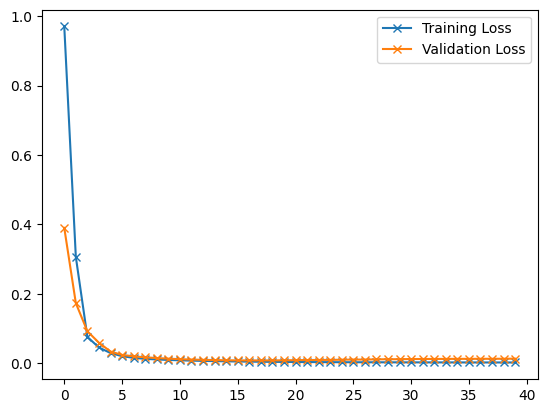

In [39]:
plt.figure()
plt.plot(trainer.train_loss, label="Training Loss", marker="x")
plt.plot(trainer.validation_loss, label="Validation Loss", marker="x")
# plt.yscale('log')
plt.legend()
loss_curves = plt.gcf()

In [40]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.1, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=15, bias=True)
    (9): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout1d(p=0.1, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=15, out_features=20, bias=True)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0003
    maximize: False
    momentum: 0.89
    nesterov: False
    w

In [41]:
from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)

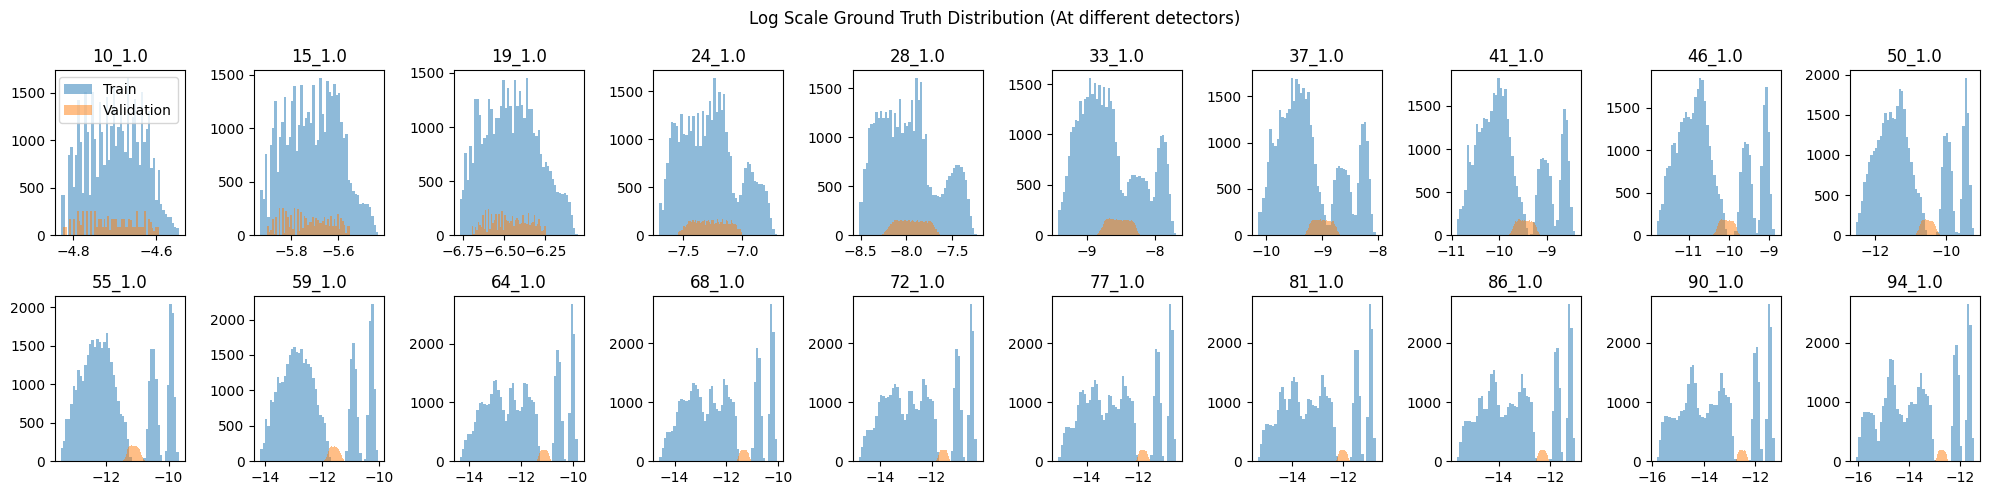

In [42]:
# Plot the ground truth data distrtibution
BIN_COUNT = 50
column_names = y_columns
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
train_data = y_scaler.inverse_transform(trainer.train_loader.dataset[:][1])
val_data = y_scaler.inverse_transform(trainer.validation_loader.dataset[:][1])


plt.suptitle("Log Scale Ground Truth Distribution (At different detectors)")
for i, ax in enumerate(axes.flat):
    if i < len(column_names):
        ax.hist(train_data[:, i], bins=BIN_COUNT, alpha=0.5, label="Train")
        ax.hist(val_data[:, i], bins=BIN_COUNT, alpha=0.5, label="Validation")
        ax.set_title(column_names[i])
        
# All figures have the same legend. Set a single legend for the entire figure
axes[0, 0].legend()
plt.tight_layout()

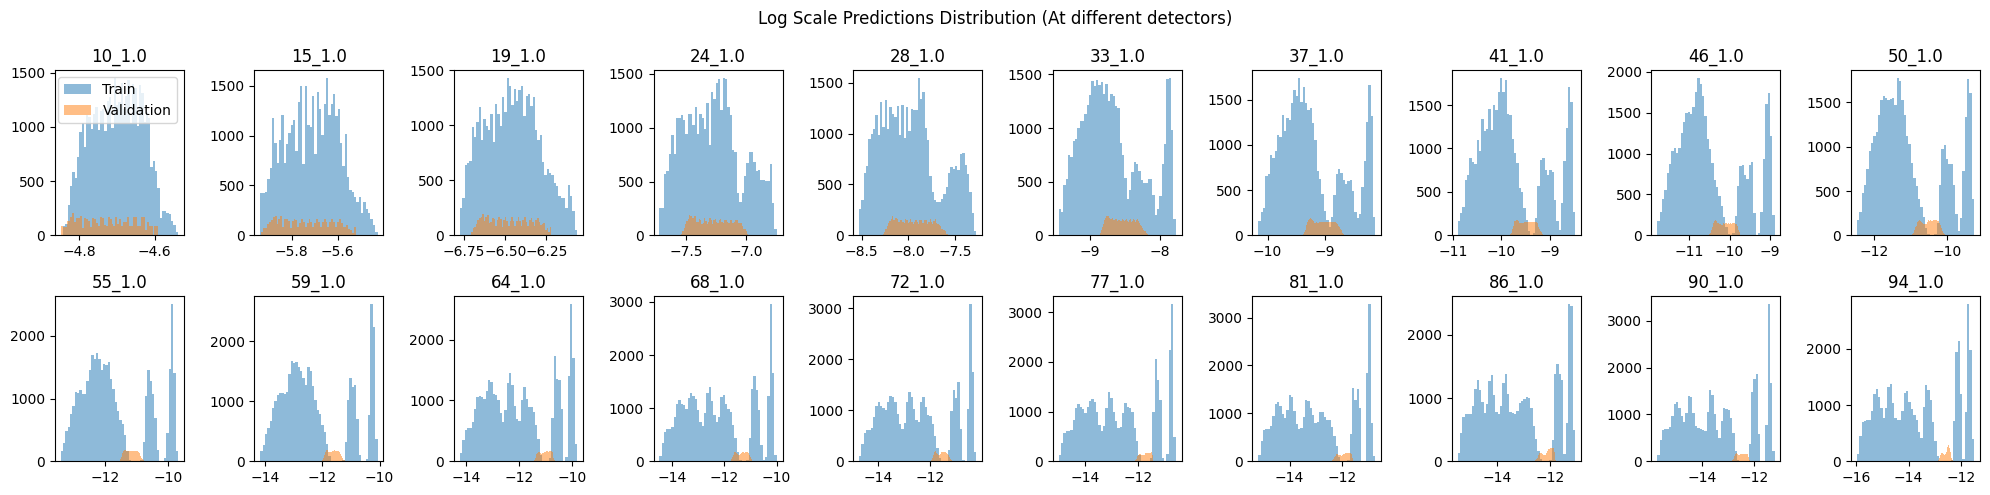

In [43]:
# Plot the prediction distribution
BIN_COUNT = 50
column_names = y_columns
fig_pred, axes = plt.subplots(2, 10, figsize=(20, 5))

plt.suptitle("Log Scale Predictions Distribution (At different detectors)")
for i, ax in enumerate(axes.flat):
    if i < len(column_names):
        ax.hist(train_pred.iloc[:, i], bins=BIN_COUNT, alpha=0.5, label="Train")
        ax.hist(val_pred.iloc[:, i], bins=BIN_COUNT, alpha=0.5, label="Validation")
        ax.set_title(column_names[i])
        
# All figures have the same legend. Set a single legend for the entire figure
axes[0, 0].legend()
plt.tight_layout()

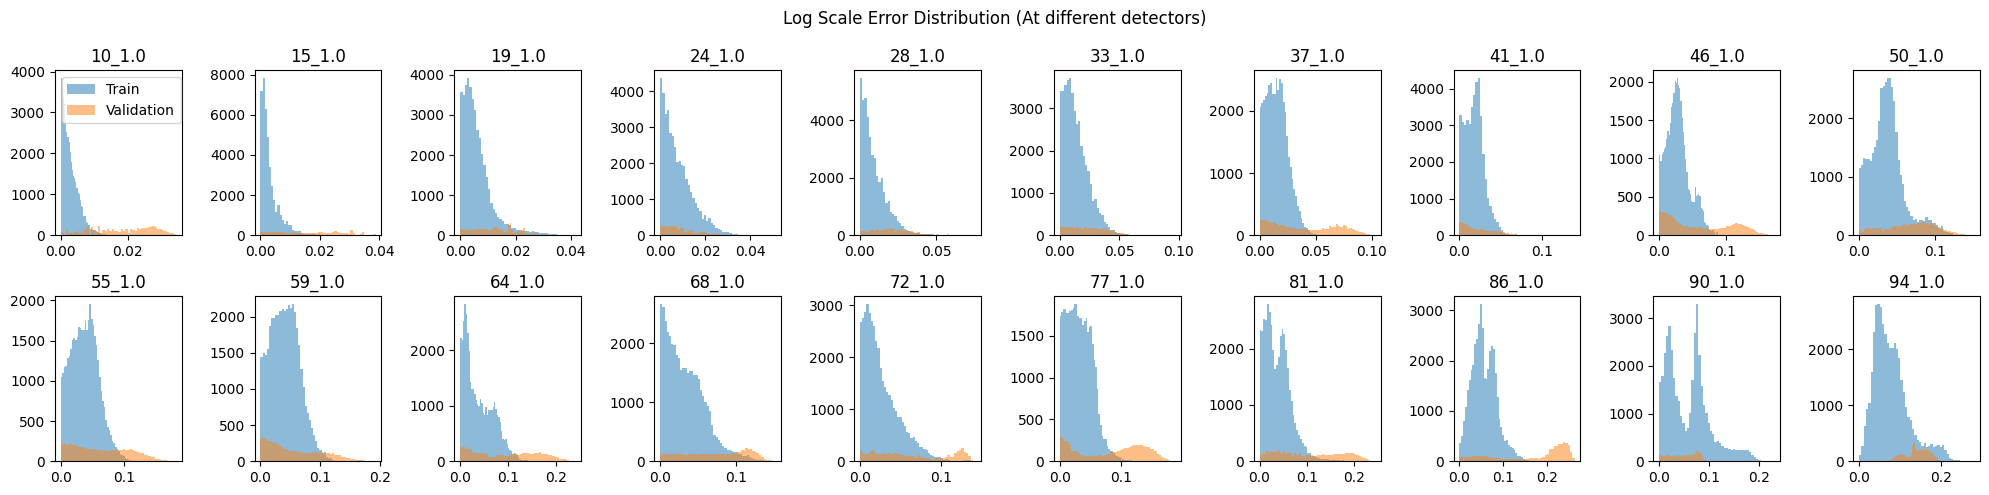

In [44]:
# Plotting the error distribution
BIN_COUNT = 50
column_names = y_columns
fig_err, axes = plt.subplots(2, 10, figsize=(20, 5))

plt.suptitle("Log Scale Error Distribution (At different detectors)")
for i, ax in enumerate(axes.flat):
    if i < len(column_names):
        ax.hist(train_error.iloc[:, i], bins=BIN_COUNT, alpha=0.5, label="Train")
        ax.hist(val_error.iloc[:, i], bins=BIN_COUNT, alpha=0.5, label="Validation")
        ax.set_title(column_names[i])
        
# All figures have the same legend. Set a single legend for the entire figure
axes[0, 0].legend()
plt.tight_layout()

In [45]:
# Rough MSE's in percentage
print(f"Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }")
print(f"Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }")

Train Error(non-normalized): [8.83105983e-06 2.60534835e-05 5.27859245e-05 1.07085009e-04
 1.85132511e-04 3.62930078e-04 5.61734005e-04 8.10818708e-04
 1.19288193e-03 1.55509838e-03 2.07857628e-03 2.55392448e-03
 3.04616686e-03 3.09032497e-03 3.13607424e-03 3.19549839e-03
 3.24482776e-03 3.30872705e-03 3.36163653e-03 3.41613717e-03]
Validation Error(non-normalized): [5.59398269e-05 1.65034253e-04 3.34369321e-04 6.78323665e-04
 1.17271096e-03 2.29895915e-03 3.55827088e-03 5.13608322e-03
 7.55624012e-03 9.85067883e-03 1.31666187e-02 1.61776838e-02
 1.92957640e-02 1.95754810e-02 1.98652770e-02 2.02416958e-02
 2.05541698e-02 2.09589361e-02 2.12940881e-02 2.16393191e-02]


In [46]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       30
│    └─BatchNorm1d: 2-2                  10
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       60
│    └─BatchNorm1d: 2-6                  20
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       165
│    └─BatchNorm1d: 2-10                 30
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      320
│    └─Flatten: 2-14                     --
Total params: 635
Trainable params: 635
Non-trainable params: 0

In [47]:
# Generate report
report = MarkdownReport(Path('results'), 'report6', 'Forward Modelling Report (WV1)')
report.add_text_report("Objective", "4 Layer network with weight decay in SGD")
report.add_text_report("Data Length", str(len(data)))
report.add_code_report("Model Used", str(torchinfo.summary(trainer.model)))
report.add_code_report("Model Trainer Params", str(trainer))
report.add_image_report("Loss Curves", loss_curves)
report.add_image_report("Prediction Distribution", fig_pred)
report.add_image_report("Error Distribution", fig_err)
report.save_report()

In [48]:
# model_name = "forward_curve_fit_paramv2"
# import joblib

# # Save Model
# torch.save(trainer.model.state_dict(), rf"../models/{model_name}")
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf"../models/{model_name}_xscaler")
# joblib.dump(y_scaler, rf"../models/{model_name}_yscaler")

In [49]:
# # Load Model Code
# import joblib
# model_name = 'forward_curve_fit_paramv1'
# fwd_model = PerceptronBD([5, 6, 8, 8], dropout_rates = [0.2, 0.2])
# fwd_model.load_state_dict(torch.load(rf'../models/{model_name}'))
# fwd_model = fwd_model.cuda()
# fwd_model = fwd_model.eval()
# # The input TMPs will already be scaled. No need to further use an x_scaler
# y_scaler_fwd = joblib.load(rf'../models/{model_name}_yscaler')
# x_scaler_fwd = joblib.load(rf'../models/{model_name}_xscaler')

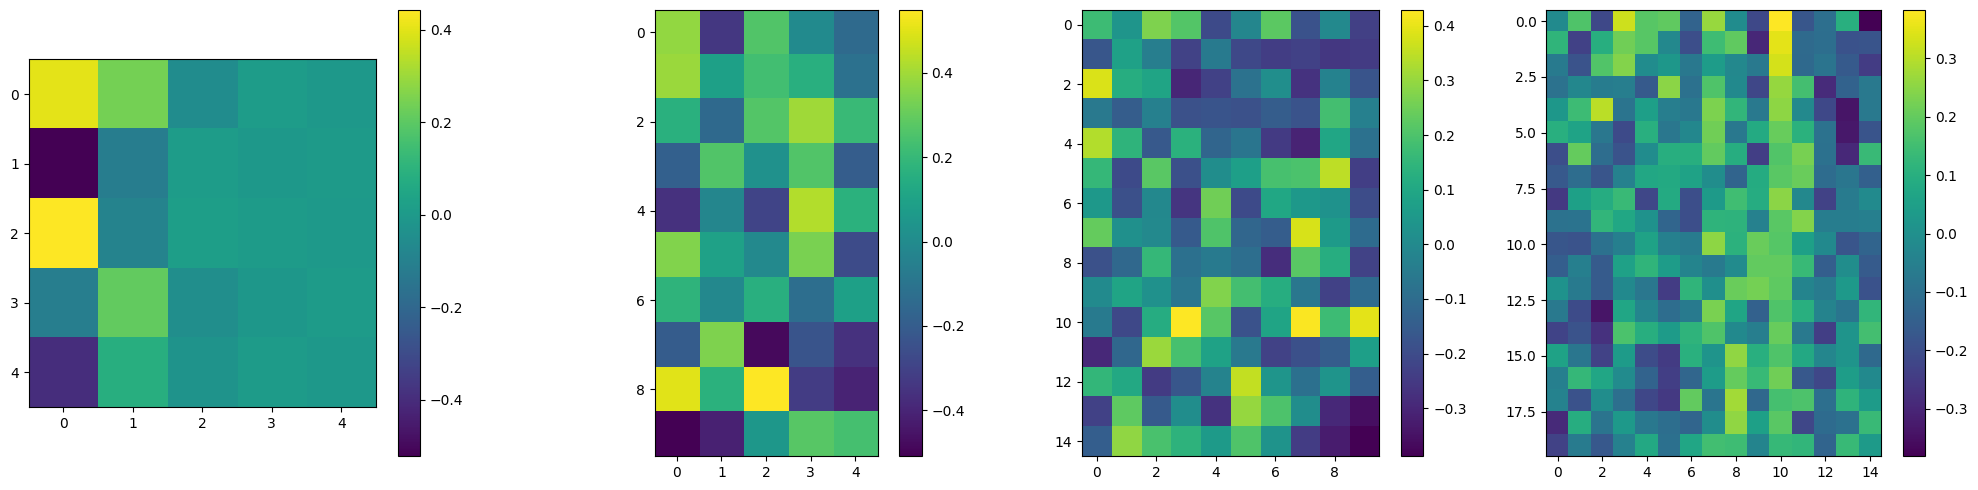

In [50]:
# Weitghts Visualization
import torch

linear_layers = [layer for layer in trainer.model.layers if isinstance(layer, torch.nn.modules.linear.Linear)]
layer_count = len(linear_layers)
fig, axes = plt.subplots(1, layer_count, figsize=(20, 5))

for i, ax in enumerate(axes.flat):
    plt.sca(ax)
    plt.imshow(linear_layers[i].weight.detach().cpu().numpy(), cmap='viridis')
    plt.colorbar()

plt.tight_layout()
plt.show()